# This is a tutorial of using spaLDVAE for detecting spatial and non-spatial genes in the human DLPFC section 151673 data

This tutorial was implemented on Macbook Pro M1.

Import modules.

In [1]:
import math, os
from time import time

import torch
from spaLDVAE import SPALDVAE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import h5py
import scanpy as sc
from preprocess import normalize, geneSelection

Setup parameters.

In [2]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'sample_151673.h5'
        self.select_genes = 0
        self.batch_size = 256
        self.maxiter = 2000
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.noise = 0
        self.dropoutE = 0
        self.dropoutD = 0
        self.encoder_layers = [128, 64]
        self.z_dim = 15
        self.beta = 10
        self.num_samples = 1
        self.fix_inducing_points = True
        self.grid_inducing_points = True
        self.inducing_point_steps = 6
        self.inducing_point_nums = None
        self.fixed_gp_params = False
        self.loc_range = 20.
        self.kernel_scale = 20.
        self.model_file = "model.pt"
        self.spatial_score_file = "spatial_score.txt"
        self.device = "cpu"

args = Args()

Setup inducing points, preprocess count matrix, and build the spaLDVAE model.

In [3]:
print(args)

data_mat = h5py.File(args.data_file, 'r')
x = np.array(data_mat['X']).astype('float64') # count matrix
loc = np.array(data_mat['pos']).astype('float64') # location information
gene_name = np.array(data_mat['gene']).astype('U26') # gene names
data_mat.close()

if args.select_genes > 0:
    importantGenes = geneSelection(x, n=args.select_genes, plot=False)
    x = x[:, importantGenes]
    gene_name = gene_name[importantGenes]
    np.savetxt("selected_genes.txt", importantGenes, delimiter=",", fmt="%i")

scaler = MinMaxScaler()
loc = scaler.fit_transform(loc) * args.loc_range

print(x.shape)
print(loc.shape)

# We provide two ways to generate inducing point, argument "grid_inducing_points" controls whether to choice grid inducing or k-means
# One way is grid inducing points, argument "inducing_point_steps" controls number of grid steps, the resulting number of inducing point is (inducing_point_steps+1)^2
# Another way is k-means on the locations, argument "inducing_point_nums" controls number of inducing points
if args.grid_inducing_points:
    eps = 1e-5
    initial_inducing_points = np.mgrid[0:(1+eps):(1./args.inducing_point_steps), 0:(1+eps):(1./args.inducing_point_steps)].reshape(2, -1).T * args.loc_range
    print(initial_inducing_points.shape)
else:
    loc_kmeans = KMeans(n_clusters=args.inducing_point_nums, n_init=100).fit(loc)
    np.savetxt("location_centroids.txt", loc_kmeans.cluster_centers_, delimiter=",")
    np.savetxt("location_kmeans_labels.txt", loc_kmeans.labels_, delimiter=",", fmt="%i")
    initial_inducing_points = loc_kmeans.cluster_centers_

adata = sc.AnnData(x, dtype="float64")
adata.var["name"] = gene_name
sc.pp.filter_genes(adata, min_cells=100)
gene_name = adata.var["name"].values.astype('U26')

adata = normalize(adata,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

model = SPALDVAE(input_dim=adata.n_vars, z_dim=args.z_dim, encoder_layers=args.encoder_layers, encoder_dropout=args.dropoutE,
    fixed_inducing_points=args.fix_inducing_points, initial_inducing_points=initial_inducing_points, 
    fixed_gp_params=args.fixed_gp_params, kernel_scale=args.kernel_scale, N_train=adata.n_obs, beta=args.beta, dtype=torch.float64, 
    device=args.device)

print(str(model))

(3639, 4000)
(3639, 2)
(49, 2)
SPALDVAE(
  (svgp): SVGP(
    (kernel): MultiMaternKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=3744, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
    (enc_mu): Linear(in_features=64, out_features=30, bias=True)
    (enc_var): Linear(in_features=64, out_features=30, bias=True)
  )
  (NB_loss): NBLoss()
)


Train the model.

In [4]:
if not os.path.isfile(args.model_file):
    t0 = time()
    model.train_model(pos=loc, ncounts=adata.X, raw_counts=adata.raw.X, size_factors=adata.obs.size_factors,
                lr=args.lr, weight_decay=args.weight_decay, batch_size=args.batch_size, num_samples=args.num_samples,
                maxiter=args.maxiter, save_model=True, model_weights=args.model_file)
    print('Training time: %d seconds.' % int(time() - t0))
else:
    model.load_model(args.model_file)

spatial_score = model.spatial_score(X=loc, Y=adata.X, batch_size=args.batch_size, gene_name=gene_name)
spatial_score.to_csv(args.spatial_score_file)

Training
Training epoch 1, ELBO:17212.11807743, NB loss:17190.89634875, GP KLD loss:0.11307718, Gaussian KLD loss:2.00909569,
Current kernel scale tensor([20.0128, 20.0136, 20.0132, 20.0130, 20.0126, 20.0138, 20.0115, 20.0106,
        20.0126, 20.0133, 20.0139, 20.0123, 20.0129, 20.0133, 20.0127])
Training epoch 2, ELBO:15546.85702431, NB loss:15528.73214145, GP KLD loss:0.13364975, Gaussian KLD loss:1.67883854,
Current kernel scale tensor([20.0267, 20.0276, 20.0272, 20.0262, 20.0255, 20.0287, 20.0249, 20.0238,
        20.0265, 20.0281, 20.0275, 20.0248, 20.0273, 20.0263, 20.0262])
Training epoch 3, ELBO:13860.68550401, NB loss:13831.01235717, GP KLD loss:0.26248291, Gaussian KLD loss:2.70483177,
Current kernel scale tensor([20.0433, 20.0443, 20.0449, 20.0369, 20.0388, 20.0454, 20.0414, 20.0423,
        20.0439, 20.0463, 20.0440, 20.0404, 20.0432, 20.0429, 20.0411])
Training epoch 4, ELBO:12020.10741024, NB loss:11959.60419841, GP KLD loss:0.88491238, Gaussian KLD loss:5.16540881,
Curr

Plotting results in R and ggplot2.

load R packages

In [1]:
rm(list=ls())
library(rhdf5)
library(scater)
library(ggplot2)
library(cowplot)
library(openxlsx)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Warning message:
“package ‘MatrixGenerics’ was built under R version 4.3.1”
Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumE

Plot top 10 spatially variable genes. Top spatial genes are selected by genes with largest spatial scores.

Warning message:
“The `switch` argument of `facet_wrap()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `strip.position` argument instead.”


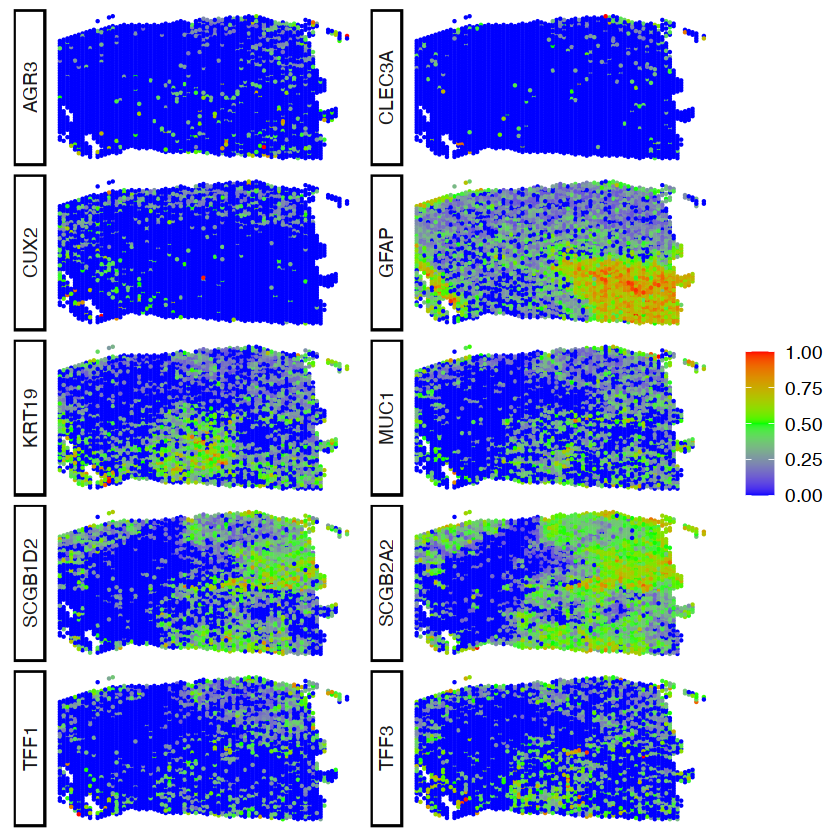

In [2]:
# annotation file for converting ENSEMBL gene ID to gene symbol
gene.anno <- read.xlsx("Human_ENSEMBL_Gene_ID_MSigDB.v7.xlsx")

spatial_score <- read.csv("spatial_score.txt", row.names = 1)

spatial_score1 <- spatial_score[order(spatial_score$spatial_score, decreasing=T), ]
spatial_score2 <- spatial_score[order(spatial_score$spatial_score, decreasing=F), ]

top_spatial_gene <- rownames(spatial_score1[1:10, ])
top_spatial_gene2 <- gene.anno[match(top_spatial_gene, gene.anno$Probe.Set.ID), "Gene.Symbol"]
top_nonspatial_gene <- rownames(spatial_score2[1:10, ])
top_nonspatial_gene2 <- gene.anno[match(top_nonspatial_gene, gene.anno$Probe.Set.ID), "Gene.Symbol"]

pos <- t(h5read("sample_151673.h5", "pos"))
pos <- data.frame(pos)
colnames(pos) <- c("x", "y")
raw.counts <- h5read("sample_151673.h5", "X")
gene <- h5read("sample_151673.h5", "gene")
cell <- h5read("sample_151673.h5", "cell")
rownames(pos) <- cell

sce <- SingleCellExperiment(list(counts=as.matrix(raw.counts)))
rownames(sce) <- gene
colnames(sce) <- cell
sce <- logNormCounts(sce, size.factors = sizeFactors(sce))
lograwcounts <- sce@assays@data$logcounts
lograwcounts <- t(apply(lograwcounts, 1, function(z) scales::rescale(z, to=c(0,1))))

spatial.gene.data <- data.frame(exp=c(lograwcounts[top_spatial_gene[1],], lograwcounts[top_spatial_gene[2],],
                                      lograwcounts[top_spatial_gene[3],], lograwcounts[top_spatial_gene[4],],
                                      lograwcounts[top_spatial_gene[5],], lograwcounts[top_spatial_gene[6],],
                                      lograwcounts[top_spatial_gene[7],], lograwcounts[top_spatial_gene[8],],
                                      lograwcounts[top_spatial_gene[9],], lograwcounts[top_spatial_gene[10],]),
                                gene=rep(top_spatial_gene2, each=nrow(pos)),
                                x=rep(pos$x, 10), y=rep(pos$y, 10))

ggplot(spatial.gene.data, aes(x=x, y=y, color=exp)) + geom_point(size=0.2) +
  facet_wrap(~gene, nrow=5, switch="y") + scale_colour_gradientn(colours=rainbow(3, rev=T)) +
  theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), text = element_text(size=14))

Plot top 10 non-spatially variable genes. Top non-spatial genes are selected by genes with largest spatial scores.

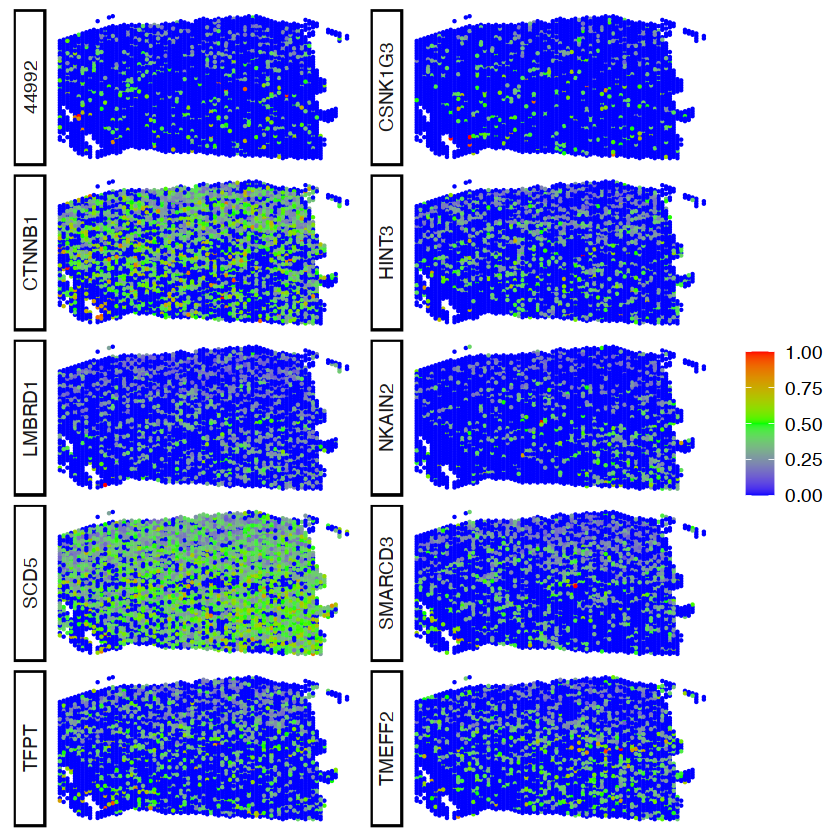

In [3]:
nonspatial.gene.data <- data.frame(exp=c(lograwcounts[top_nonspatial_gene[1],], lograwcounts[top_nonspatial_gene[2],],
                                      lograwcounts[top_nonspatial_gene[3],], lograwcounts[top_nonspatial_gene[4],],
                                      lograwcounts[top_nonspatial_gene[5],], lograwcounts[top_nonspatial_gene[6],],
                                      lograwcounts[top_nonspatial_gene[7],], lograwcounts[top_nonspatial_gene[8],],
                                      lograwcounts[top_nonspatial_gene[9],], lograwcounts[top_nonspatial_gene[10],]),
                                gene=rep(top_nonspatial_gene2, each=nrow(pos)),
                                x=rep(pos$x, 10), y=rep(pos$y, 10))

ggplot(nonspatial.gene.data, aes(x=x, y=y, color=exp)) + geom_point(size=0.2) +
  facet_wrap(~gene, nrow=5, switch="y") + scale_colour_gradientn(colours=rainbow(3, rev=T)) +
  theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), text = element_text(size=14))